In [1]:
suppressPackageStartupMessages(library(clusterProfiler))
library(magrittr)
library(tidyverse)
library(cowplot)
library(UpSetR)

palette <- c('HSIC Lasso' = '#c994c7', 
             'Block HSIC Lasso, B = 50' = '#df65b0',
             'Block HSIC Lasso, B = 20' = '#e7298a', 
             'Block HSIC Lasso, B = 10' = '#ce1256',
             'Block HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 
             'Raw' = 'gray70')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
methods <- c('HSIC Lasso', 'Block HSIC Lasso, B = 50',
             'Block HSIC Lasso, B = 20','Block HSIC Lasso, B = 10',
             'Block HSIC Lasso, B = 5', 'mRMR', 'LARS')
palette_yn = c("Yes" = "#91cf60", "No" = "gray90")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
✖ purrr::simplify()  masks clusterProfiler::simplify()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



# Supplementary figure 1

In [2]:
summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    methods <- c('HSIC Lasso', 'mRMR', 
             'Block HSIC Lasso, B = 10', 'LARS',
             'Block HSIC Lasso, B = 5', 'Raw')
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- summarize_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- summarize_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- summarize_benchmark('../results/asu/warpPIE10P_prediction.tsv')

prediction_img <- bind_rows(pixraw10P, warpAR10P, orlraws10P, warpPIE10P)

face_recognition <- prediction_img %>%
    filter(model != 'Raw') %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_img, model == 'Raw'), 
                   aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank(),
              rect = element_rect(fill = "transparent")) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Algorithm') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 2) +
        guides(color = guide_legend(nrow = 3, byrow = TRUE))

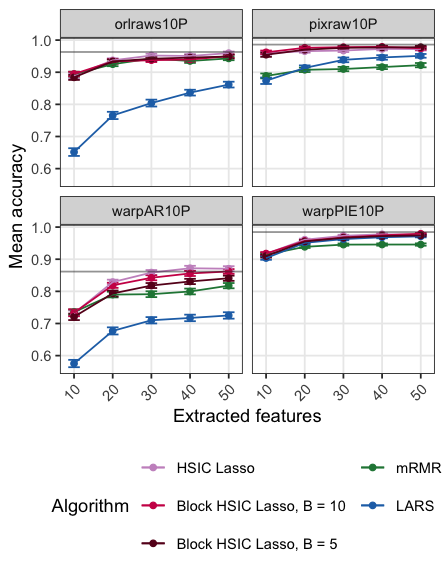

In [3]:
ggsave('img/Climente-Gonzalez.11.sup.1.pdf', face_recognition, width = 3.7, height = 4.8, dpi = 1200)
options(repr.plot.width = 3.7, repr.plot.height = 4.8)
face_recognition

# Supplementary figure 2

In [4]:
df <- read_tsv('../results/covariates/continuous_feature_selection.tsv', 
                     col_types = 'ciiiiid') %>%
    filter(samples == 1000 & causal == 5) %>%
    mutate(covars = ifelse(grepl('_no_covars', model), 'Unadjusted', 'Adjusted'),
           model = gsub('_no_covars', '', model),
           model = gsub('_covars', '', model),
           model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = ifelse(grepl('-B=', model), paste0('Block ', model), model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods)) %>%
    group_by(model, covars, samples, features) %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected))

covars <- ggplot(df, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(legend.position = 'bottom',
          rect = element_rect(fill = "transparent")) +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ covars) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette) +
    guides(color = guide_legend(nrow = 2, byrow = TRUE))

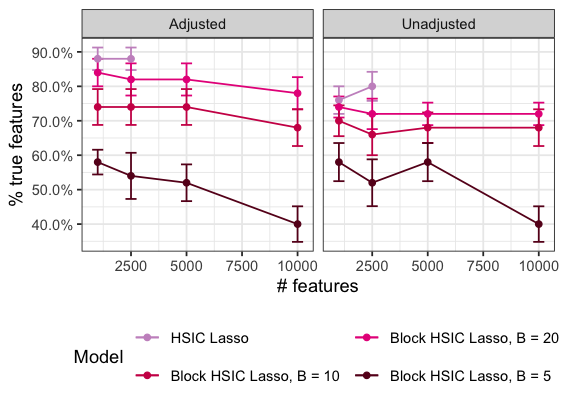

In [5]:
ggsave('img/Climente-Gonzalez.11.sup.2.pdf', covars, width = 4.7, height = 3.4, dpi = 1200)
options(repr.plot.width=4.7, repr.plot.height=3.4)
covars

# Supplementary figure 3

In [6]:
summarize_benchmark <- function(label) {
    
    methods <- c('Block HSIC Lasso, B = 20','Block HSIC Lasso, B = 5', 'LARS',
                 'Block HSIC Lasso, B = 10', 'mRMR', 'Raw')
    
    read_tsv(paste0('../results/single_cell/', label, '_prediction.tsv'), col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
        ungroup %>%
        mutate(label = paste(tools::toTitleCase(label), 'et al.'))

}

sc <- bind_rows(summarize_benchmark('haber'), summarize_benchmark('habib'), summarize_benchmark('villani'))

raw <- filter(sc, model == 'Raw')
sc <- filter(sc, model != 'Raw')

sc <- ggplot(sc, aes(x = selected, y = accuracy, color = model)) +
    geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
    geom_point() +
    geom_line() +
    geom_hline(data = raw, aes(yintercept = accuracy), size = 0.7, 
               colour = 'gray20', alpha = 0.5) + 
    theme_bw() +
    theme(legend.position = 'bottom',
          axis.text.x = element_text(angle = 45, hjust = 1),
          rect = element_rect(fill = "transparent")) +
    labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Algorithm') +
    scale_color_manual(values = palette) +
    facet_grid(. ~ label) + 
    guides(color = guide_legend(nrow = 2, byrow = TRUE))

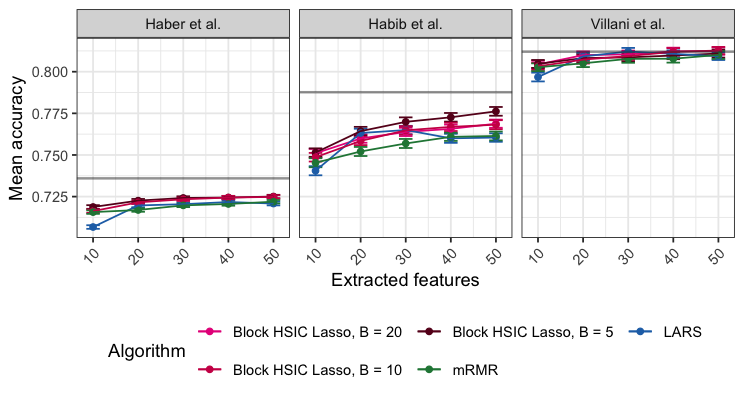

In [7]:
ggsave('img/Climente-Gonzalez.11.sup.3.pdf', sc, width = 6.2, height = 3.35, dpi = 1200)
options(repr.plot.width=6.2, repr.plot.height=3.35)
sc

# Supplementary figure 5

In [8]:
options(repr.plot.width=4, repr.plot.height=3.5)

gwas_exps <- c('t1d', 't2d', 'ra')

lapply(gwas_exps, function(pheno) {
    
    results <- '../results/gwas/' 
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                     col_names = F, col_types = 'c') %>%
        head(10) %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        filter(SNP %in% selected & P < (.05 / (4 * n()))) %>%
        mutate(TEST = ifelse(TEST == 'GENO', 'Genotypic', TEST),
               TEST = ifelse(TEST == 'DOM', 'Dominance', TEST),
               TEST = ifelse(TEST == 'TREND', 'Trend', TEST),
               TEST = ifelse(TEST == 'REC', 'Recessive', TEST),
               TEST = ifelse(TEST == 'ALLELIC', 'Allelic', TEST)) %>%
        select(SNP, TEST)
    
    gwas <- fromList(split(gwas$SNP, gwas$TEST))
    
    pdf(file=paste0('img/Climente-Gonzalez.11.sup.5.', pheno , '.pdf'), onefile=FALSE,
        width=4, height=3.5)
    
    upset(gwas, order.by = "freq", 
          sets.x.label = 'Block HSIC Lasso overlap', 
          mainbar.y.label = 'Intersection size', 
          mb.ratio = c(.6, .4), 
          point.size = 3.5, line.size = 1.2)
    
    dev.off()

})

[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2

# Supplementary figure 6

In [9]:
pdf(file='img/Climente-Gonzalez.11.sup.6.pdf', onefile=FALSE, width=4, height=2.5)

gwas_exps <- c('t1d', 't2d', 'ra')

results <- '../results/gwas/'
selected <- list(
    LARS = lapply(gwas_exps, function(e) {
        read_tsv(paste0(results, e, '/', e, '_lars_C=10.txt'), 
                    col_names = F, col_types = 'c') %>% .$X1 }) %>% unlist %>% c,
    mRMR = lapply(gwas_exps, function(e) {
        read_tsv(paste0(results, e, '/', e, '_mrmr_C=10.txt'), 
                 col_names = F, col_types = 'c') %>% .$X1 }) %>% unlist %>% c,
    `Block HSIC Lasso (B = 60)` = lapply(gwas_exps, function(e) {
        read_tsv(paste0(results, e, '/', e, '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                 col_names = F, col_types = 'c') %>% head(10) %>% .$X1 }) %>% unlist %>% c)

upset(fromList(selected), order.by = "freq", 
      sets.x.label = '# selected biomarkers', 
      mainbar.y.label = 'Intersection size', 
      mb.ratio = c(.6, .4))

dev.off()

pdf 
  2

# Supplementary figure 4

In [10]:
read_predictions <- function(label) {
    
    x <- bind_rows(read_tsv(paste0('../results/single_cell/', label, '_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'HSIC Lasso') %>% head(n = 20),
          read_tsv(paste0('../results/single_cell/', label, '_lars_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'LARS'),
          read_tsv(paste0('../results/single_cell/', label, '_mrmr_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'mRMR'))
    
    # number of features selected
    print(table(x$Method))

    # number of features selected by more than one method
    x %>%
        group_by(Gene) %>%
        summarize(n = as.character(n())) %>%
        filter(n > 1) %>%
        print
    
    return(x)
    
}

gene2pathway <- function(genes, pathways) {
    
    rank <- inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        group_by(ont) %>%
        summarize(n = length(unique(Method)))

    left_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        left_join(rank, by = "ont") %>%
        arrange(-n) %>%
        group_by(Gene, Method) %>%
        summarize(ont = head(ont, 1)) %>%
        ungroup
    
}

plot_pathways <- function(genes, pathways) {
    
    gene2pathway(genes, pathways) %>%
        filter(!is.na(ont)) %>%
        group_by(ont) %>%
        filter(length(unique(Method)) >= 2) %>%
        ungroup %>%
        ggplot(aes(fct_infreq(ont), fill = Method)) +
            geom_bar() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position = 'bottom',
                  rect = element_rect(fill = "transparent")) +
            labs(x = '', y = 'Count') +
            coord_flip() +
            scale_fill_manual(values = palette)
    
}

In [11]:
habib <- read_predictions('habib')

pathways_mouse <- suppressPackageStartupMessages(
    read.gmt(gmtfile = "../data/Mus_musculus_GSEA_GO_sets_bp_symbols_highquality_April_2015.gmt")) %>%
    mutate(ont = gsub('\\([0-9]\\)', '', ont),
           gene = tools::toTitleCase(tolower(gene)),
           ont = tools::toTitleCase(ont),
           ont = gsub('_', ' ', ont))

detach(package:clusterProfiler)


HSIC Lasso       LARS       mRMR 
        20         16         20 
# A tibble: 0 x 2
# … with 2 variables: Gene <chr>, n <chr>


In [12]:
markers <- c(read_tsv('~/data/single_cell/habib/Major_cell_types_marker_genes.txt',
                      col_types = 'cddddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/Glia_subcluster_marker_genes.txt',
                         col_types = 'cdddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/GABAergic_edit_subcluster_marker_gene.txt',
                         col_types = 'cdddddddd') %>% .$`GENE NAMES`)

markers_pwy <- tibble(Gene = markers, Method = 'Known genes') %>%
    gene2pathway(pathways_mouse) %>%
    .$ont %>%
    unique %>%
    na.omit

known_genes <- habib %>% 
    mutate(known_gene = ifelse(Gene %in% markers, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_gene)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known gene?') +
        theme_bw() +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank(),
              rect = element_rect(fill = "transparent"))

known_pwy <- gene2pathway(habib, pathways_mouse) %>%
    mutate(known_pwy = ifelse(ont %in% markers_pwy, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_pwy)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known BP?') +
        theme_bw() +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank(),
              rect = element_rect(fill = "transparent"))

known_bm <- plot_grid(known_genes, known_pwy, labels = c('A','B'))

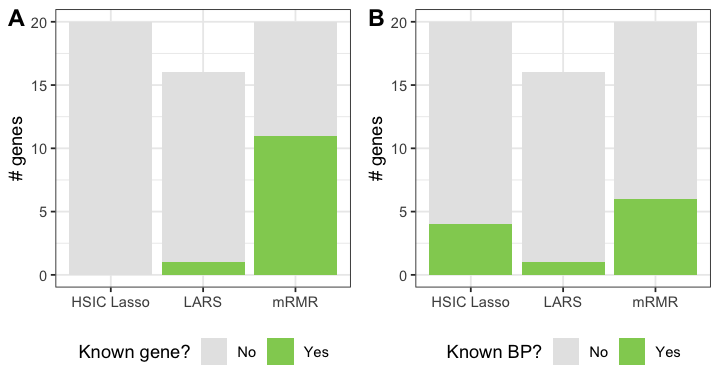

In [13]:
ggsave('img/Climente-Gonzalez.11.sup.4.pdf', known_bm, width = 6, height = 3.2)
options(repr.plot.width=6, repr.plot.height=3.2)
known_bm